In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
from sklearn.metrics import confusion_matrix

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open
import config_origins as config

C:\Users\camil\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\camil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
path_extracted_data = config.path_extracted_data
id_run = config.id_run
path_cleaning_records = r'R:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\GantnerSystem\GantnerCleaning\Results'
#path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning = r'D:\vm_exchange\PhD_Data\LogsCleaning'
#create a director if not existing
if not os.path.exists(path_extracted_data_cleaning):
    os.makedirs(path_extracted_data_cleaning)

## Download video obs data

In [4]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
#important not to cheat: take on the clenaing data!!
df = df[df['algo_type']=='cleaning']
print(df.shape)
df.head(3)

(3222, 36)


,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,next_duration,BatchID,zone2_match,zone3_match,zone4_match,ObservedZone,zone3_match_exist,next2zone==Zone,previous2zone==Zone
0,2020-10-23 08:45:39,91,164.0,1_Zone,9.0,0,8 - 9,2020-10-23,logs,6.0,...,True,1753.0,NaN,2_Zone,NoOtherZone,NoOtherZone,2_Zone,False,False,False
1,2020-10-05 15:13:28,130,49.0,1_Zone,10.0,0,10 - 12,2020-10-05,logs,5.0,...,True,112.0,NaN,2_Zone,NoOtherZone,NoOtherZone,2_Zone,False,True,True
2,2020-10-17 10:41:09,107,5.0,1_Zone,9.0,0,8 - 9,2020-10-17,logs,5.0,...,True,299.0,NaN,2_Zone,5_Zone,NoOtherZone,2_Zone,True,True,True


## Percentage of duration associated to a wrong zone due to missed/added records from the tracking system (i.e. not due to delay)

In [5]:
df.head(3)

,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,next_duration,BatchID,zone2_match,zone3_match,zone4_match,ObservedZone,zone3_match_exist,next2zone==Zone,previous2zone==Zone
0,2020-10-23 08:45:39,91,164.0,1_Zone,9.0,0,8 - 9,2020-10-23,logs,6.0,...,True,1753.0,NaN,2_Zone,NoOtherZone,NoOtherZone,2_Zone,False,False,False
1,2020-10-05 15:13:28,130,49.0,1_Zone,10.0,0,10 - 12,2020-10-05,logs,5.0,...,True,112.0,NaN,2_Zone,NoOtherZone,NoOtherZone,2_Zone,False,True,True
2,2020-10-17 10:41:09,107,5.0,1_Zone,9.0,0,8 - 9,2020-10-17,logs,5.0,...,True,299.0,NaN,2_Zone,5_Zone,NoOtherZone,2_Zone,True,True,True


In [6]:
df['VideoAnalyse'].value_counts()

1    2609
0     613
Name: VideoAnalyse, dtype: int64

In [7]:
df[df['VideoAnalyse']==1][['TagID', 'Timestamp', 'duration']]

,TagID,Timestamp,duration
118,78,2020-10-11 14:33:23,296.0
120,79,2020-10-11 14:59:00,48.0
121,185,2020-10-11 15:07:57,909.0
122,79,2020-10-11 15:09:16,16.0
124,185,2020-10-11 15:47:37,533.0
...,...,...,...
4080,138,2020-10-23 14:57:48,45.0
4081,138,2020-10-23 14:58:33,29.0
4082,138,2020-10-23 14:59:02,73.0
4083,138,2020-10-23 15:00:15,22.0


In [8]:
df[df['VideoAnalyse']==0][['TagID', 'Timestamp', 'duration']]

,TagID,Timestamp,duration
0,91,2020-10-23 08:45:39,23.0
1,130,2020-10-05 15:13:28,51.0
2,107,2020-10-17 10:41:09,31.0
3,170,2020-10-05 12:40:44,68.0
4,95,2020-10-26 05:15:40,136.0
...,...,...,...
3867,39,2020-10-26 15:40:34,5.0
3888,42,2020-10-24 14:35:37,36.0
3953,138,2020-10-23 09:17:41,3.0
3955,138,2020-10-23 09:30:47,4.0


In [9]:
#correct duration
df_correct_dur = df[df['VideoAnalyse']==1].groupby(['PenID','HenID'])['duration'].sum().reset_index()
df_correct_dur.rename(columns={'duration':'correct_duration'}, inplace=True)
#incorrect duration
df_incorrect_dur = df[df['VideoAnalyse']==0].groupby(['PenID','HenID'])['duration'].sum().reset_index()
df_incorrect_dur.rename(columns={'duration':'incorrect_duration'}, inplace=True)
df_dur = pd.merge(df_correct_dur, df_incorrect_dur, on=['PenID','HenID'], how='outer')
print(df_dur.head(3))
print(df_dur.shape)
df_dur['incorrect_duration'] = df_dur['incorrect_duration'].fillna(0)
df_dur['correct_duration'] = df_dur['correct_duration'].fillna(0)
df_dur['percentage_correct_durations'] = df_dur.apply(lambda x: x['correct_duration']/(x['correct_duration']+x['incorrect_duration']*100),
                                                    axis=1)
display(df_dur.groupby(['PenID'])['HenID','percentage_correct_durations'].agg(lambda x: list(x)).reset_index())

   PenID  HenID  correct_duration  incorrect_duration
0    3.0   20.0           26409.0               426.0
1    3.0   25.0            4104.0               339.0
2    3.0   40.0           26198.0              1383.0
(62, 4)


C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,PenID,HenID,percentage_correct_durations
0,3.0,"[20.0, 25.0, 40.0, 92.0, 104.0]","[0.3826892144502891, 0.10798863277549732, 0.15..."
1,4.0,"[48.0, 50.0, 58.0, 64.0, 79.0, 150.0, 152.0, 1...","[1.0, 0.2687136627906977, 0.9918887789367812, ..."
2,5.0,"[12.0, 88.0, 166.0, 167.0]","[0.024611296950667667, 0.03154719115688747, 0...."
3,8.0,"[44.0, 51.0, 62.0, 69.0, 74.0, 77.0, 126.0, 14...","[0.29980903882877147, 0.23579736614438143, 0.6..."
4,9.0,"[105.0, 113.0, 5.0, 19.0, 23.0, 24.0, 29.0, 31...","[0.06005386420550297, 0.01934183495484321, 0.0..."
5,10.0,"[46.0, 49.0, 54.0, 65.0, 141.0, 143.0, 177.0, ...","[0.667131134850596, 0.13755458515283842, 0.544..."
6,11.0,"[9.0, 14.0, 91.0]","[0.0, 0.0, 0.0]"
7,12.0,"[122.0, 45.0, 47.0, 160.0]","[1.0, 0.0, 0.0, 0.0]"


In [10]:
df_dur[df_dur['PenID']==4]

,PenID,HenID,correct_duration,incorrect_duration,percentage_correct_durations
5,4.0,48.0,13798.0,0.0,1.000000
6,4.0,50.0,5916.0,161.0,0.268714
7,4.0,58.0,61143.0,5.0,0.991889
8,4.0,64.0,9820.0,36.0,0.731744
9,4.0,79.0,9053.0,0.0,1.000000
10,4.0,150.0,7044.0,237.0,0.229118
11,4.0,152.0,16098.0,261.0,0.381487
12,4.0,153.0,7306.0,198.0,0.269534


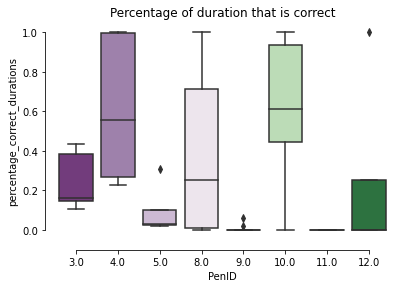

In [11]:
#multiple boxplot
sns.boxplot(x='PenID', y='percentage_correct_durations', data=df_dur, palette="PRGn") 
sns.despine(offset=10, trim=True)
plt.title('Percentage of duration that is correct');
#plt.savefig(os.path.join(path_extracted_data_cleaning, 'percentage_correct_durations.png'), dpi=300, format='png')

## Signal strength

In [12]:
#lets count each entry only one time if the students agree on the output, and not if the students did not agree on the output
df_signstr = df[df['VideoAnalyse'].isin([0,1])].groupby(['HenID','PenID','Timestamp'])['VideoAnalyse',
                                                                         'signalstrength','Zone'].agg(lambda x: list(x)).reset_index()
df_signstr['ss_variance'] = df_signstr['VideoAnalyse'].map(lambda x: np.var(x))
df_signstr = df_signstr[df_signstr['ss_variance']==0]
df_signstr['VideoAnalyse'] = df_signstr['VideoAnalyse'].map(lambda x: x[0])
df_signstr['signalstrength'] = df_signstr['signalstrength'].map(lambda x: x[0])
df_signstr['Zone'] = df_signstr['Zone'].map(lambda x: x[0])
#df_signstr.groupby(['Pen','Zone','VideoAnalyse'])['signalstrength'].agg(lambda x)
df_signstr.head(2)

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,HenID,PenID,Timestamp,VideoAnalyse,signalstrength,Zone,ss_variance
0,5.0,9.0,2020-10-14 09:47:27,0,5.0,1_Zone,0.0
1,5.0,9.0,2020-10-14 10:04:11,0,5.0,1_Zone,0.0


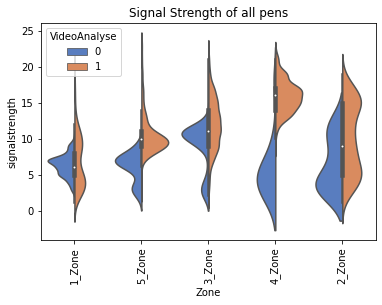

In [13]:
ax = sns.violinplot(x="Zone", y="signalstrength", hue="VideoAnalyse",data=df_signstr, palette="muted", split=True)
plt.title('Signal Strength of all pens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.savefig(os.path.join(path_extracted_data_cleaning, 'Signal Strength of all pens.png'),dpi=300,format='png')
plt.show()

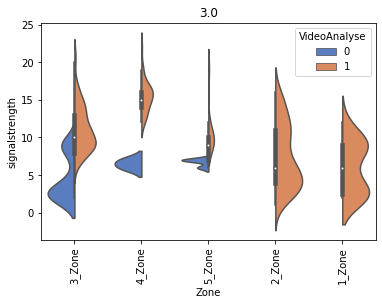

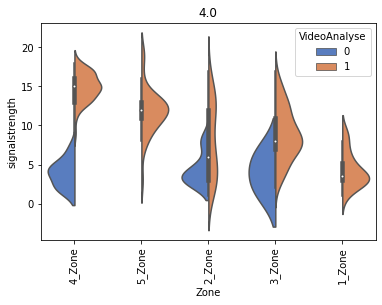

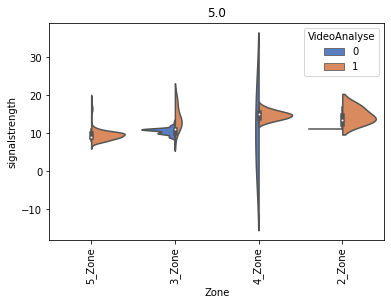

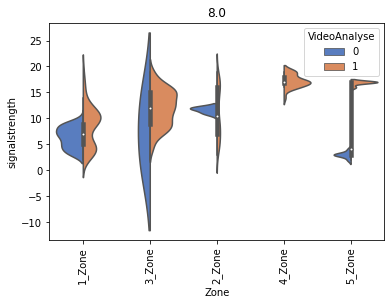

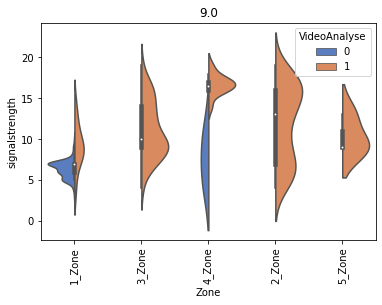

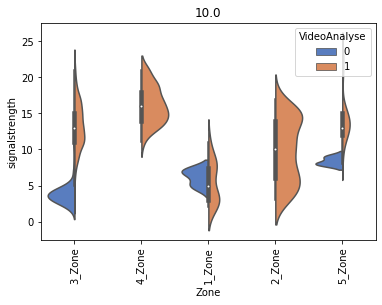

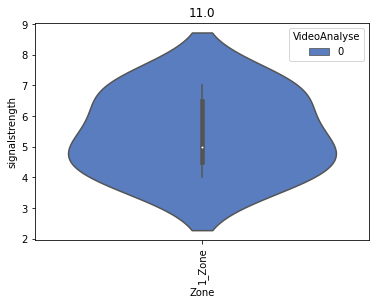

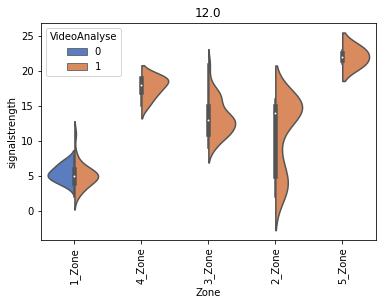

In [14]:
for p,df_ in df_signstr.groupby('PenID'):
    if len(df_['VideoAnalyse'].unique())==2:
        ax = sns.violinplot(x="Zone", y="signalstrength", hue="VideoAnalyse",data=df_, palette="muted", split=True)
        plt.title(p)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #plt.savefig(os.path.join(path_extracted_data_cleaning, 'Signal Strength pen'+str(p)+'.png'),dpi=300,format='png')
        plt.show()
    else:
        ax = sns.violinplot(x="Zone", y="signalstrength", hue="VideoAnalyse",data=df_, palette="muted")
        plt.title(p)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #plt.savefig(os.path.join(path_extracted_data_cleaning, 'Signal Strength pen'+str(p)+'.png'),dpi=300,format='png')
        plt.show()